In [ ]:
# --- File paths and packages
from pathlib import Path

PROJECT_ROOT = Path.cwd().resolve()
if not (PROJECT_ROOT / "src").exists() and (PROJECT_ROOT.parent / "src").exists():
    PROJECT_ROOT = PROJECT_ROOT.parent

myFile = "demo_soc_256_50000/soc_fire_sizes_256_50000.txt"
workDir = str(PROJECT_ROOT) + "/data/"
myPath = str(workDir + myFile)

import numpy as np
import matplotlib.pyplot as plt

**Reader's note**

This notebook is intentionally written as a working document. It records exploratory reasoning, toy models, intermediate results, and questions that arise while learning about cascade dynamics from first principles.

The aim is not polish or completeness, but transparency: showing how simple assumptions lead to particular behaviours, and where those assumptions break down. This reflects how I work when approaching unfamiliar technical domains — building intuition incrementally before adding complexity.

Readers interested primarily in motivation and scope may prefer to start with *Notebook 0 – Preface & Vision*.

---

# Modelling Cascades in Cyber Systems

---

## Notebook 1: An Introduction to Self-Organising, Critical Systems: Cascades, Criticality and Why They Matter

## A Thought Experiment

Imagine you’re absent-mindedly dropping grains of sand into a little pile. Most of the time nothing dramatic happens — a few grains shift, settle, and the system carries on. Every so often a larger patch cascades down one side. And very rarely, the whole face collapses.

The internet behaves a bit like that. It keeps growing — more users, more devices, more cloud services, more interdependence. As it grows, little disturbances happen all the time: a minor outage, a service reset, a small cyber incident. These are the tiny sand-slips we hardly notice. Occasionally a larger chunk moves — a big provider goes down, or a disruption ripples through multiple services. And rarely, you get a major cascade: multiple networks, suppliers or cloud platforms affected at once.

What’s interesting is that, just like with the sandpile, we often can’t know exactly which disturbance will stay tiny and which one will cascade. The system’s behaviour depends on how *loaded*, stressed, or interconnected things have become at that moment. Some small nudge can stay local... or it can trigger something much larger.

This pattern — many small events, fewer medium ones, and rare but extremely large cascades — is one of the hallmarks of a class of systems sometimes described as **self-organised critical (SOC)**. They sit on the knife-edge between stability and instability, where small perturbations can have wildly variable outcomes.


## The Drossel-Schwabl SOC forest-fire model

To build up intuition for these ideas — connectivity, cascades, criticality, scale-free behaviour, correlation length, percolation and finite-size effects — we will start with one of the simplest (SOC) systems ever devised: the Drossel–Schwabl forest-fire model.

We are not using it because forests are a metaphor for cyber. We are using it because it is:
- **visual** — you can see a cascade propagate

- **intuitive** — local rules produce global behaviour

- **mathematically rich** — power laws, thresholds, scaling, correlation lengths

- **controllable** — we can drive it slowly, observe it, and measure everything

The Drossel–Schwabl model is one of the most intuitive SOC systems available. It gives us a “sandbox” where:
- **connectivity** is explicit (a 2-D grid with orthogonal neighbours)

- **nodes** (trees) occupy discrete sites

- **drive** (tree growth) happens slowly

- **dissipation** (fires) happens quickly

- **cascades** produce measurable structures (clusters, radii, durations)

- **criticality** emerges automatically when drive ≪ dissipation

If you want to explain cascades to someone who has never heard the word “power law”, this model is as close as we get to visual intuition. Later, when we pivot to cyber, we will replace “trees” with devices, services or vulnerabilities, and “fires” with cascading failures or compromises — but the structural logic is the same. All of these concepts will carry across into the much less visually intuitive world of networks and IoT ecosystems.


#### A semi-official description of the Drossel–Schwabl SOC forest model

The system is defined on an $L \times L$ **square lattice**, where each site can be in one of three states:

1. **Empty** (no tree)

2. **Tree** (a node that can propagate a cascade)

3. **Burning** (a node currently participating in a cascade)


At each time step:

1. Growth:
    - With probability $p$, an empty site becomes a tree.
    - (This is the “slow drive”.)

2. Lightning:
    - With probability $f \ll p$, a random site is struck.
    - If it contains a tree, it ignites.

3. Fire propagation:
    - Burning nodes ignite their Von Neumann neighbours (N, E, S, W).
    - After burning for one step, a site becomes empty.
    - (This is the “fast dissipation”.)

When the ratio $f/p$ → $0$, the system naturally self-organises into a critical state. No external tuning is required. Any lightning strike can trigger anything from a one-site event to a system-spanning cascade.

This is exactly the behaviour we want to understand before we attempt to map similar dynamics onto cyber ecosystems.


#### Connectivity in the SOC forest model

The model uses **Von Neumann connectivity**: each node is connected to its four orthogonal neighbours. This is one of the simplest connectivity structures we can study, and therefore a good starting point when building intuition about cascades. (For completeness, an alternative is **Moore connectivity**, which includes diagonals, giving 8 neighbours. We will mention this occasionally, but our baseline model uses Von Neumann.)

**How far and how fast a cascade spreads is governed entirely by connectivity.** The forest gives us a controlled environment where we can see this play out, frame by frame.

Below are some screenshots showing the evolution of a large cascade that began on the lower boundary, slightly right of centre, and propagated through the lattice.

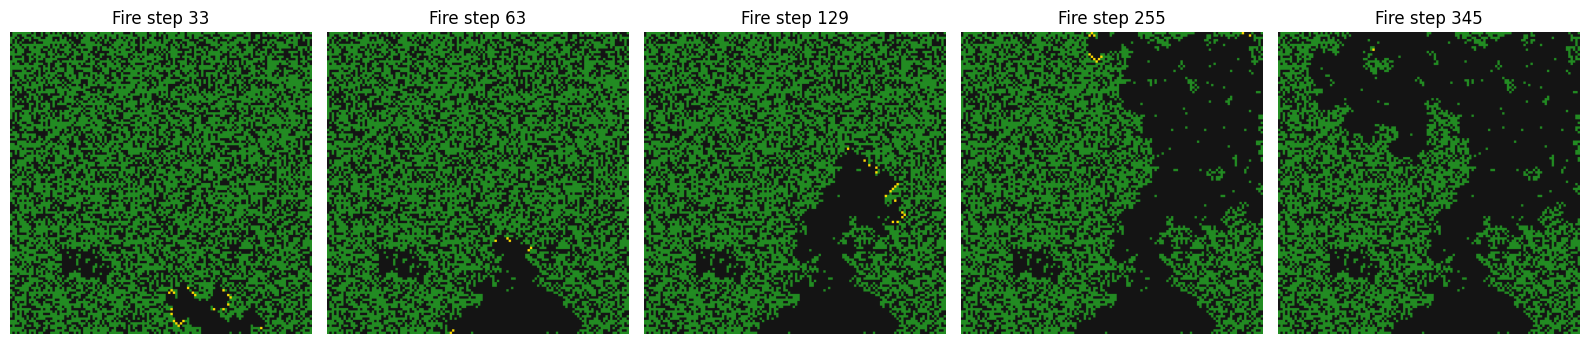

In [8]:
# --- Screenshots
# 5 screenshots at steps ~32, 64, 128, 256 and 345

# limit max_runs to 4, select fires, log_interval = 1, seed = 1138 (or 1??)

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

imgDir = str(PROJECT_ROOT) + "/data/socsim_automatic_screenshots/"
imageNos = [33, 63, 129, 255, 345]
filenamePrefix = "fire_00004_step_"
paths = [imgDir + filenamePrefix + str(i).zfill(5) + ".png" for i in imageNos]
titles = [str(i) for i in imageNos]

fig, axes = plt.subplots(1, 5, figsize=(16, 4))

for ax, path, title in zip(axes, paths, titles):
    img = mpimg.imread(path)
    ax.imshow(img)
    ax.axis("off")
    ax.set_title("Fire step " + title)

plt.tight_layout()
plt.show()


---

## Self-Organised Criticality: Core Characteristics

### 1. Slow driving, fast dissipation

A self-organised critical system is defined by a separation of timescales:
- **Load accumulates slowly**

- **Load is released rapidly in bursts**

This pattern appears across different domains:

- **Sandpiles**: grains are added slowly; avalanches occur instantaneously.

- **Forest-fire models**: trees grow slowly; fires burn through clusters in a single step.

- **Cyber systems**: interconnections, dependencies and latent vulnerabilities build over long periods; failures or outages propagate rapidly once triggered.

This asymmetry — slow build-up, fast release — is essential. Without it, we do not see the emergence of cascades spanning many possible sizes. The system needs time to organise itself into a fragile, extended structure before dissipation events can reveal that structure.


#### What we see in the time series

In the figure below, the **blue** lines indicate periods where the node density increases (the “drive”), and the **orange** lines indicate density decreases (the “dissipation” caused by fires).

A few important observations:

1. **The system hovers in a band between ~0.2 and ~0.59 density.** It never empties itself completely after a cascade (the minimum stays above ≈0.2 in this simulation), nor does it ever climb much beyond the **percolation threshold**. The system naturally settles into this dynamic range.

2. **Being near the percolation threshold does not guarantee a large cascade.** The lattice can be highly loaded and yet produce only small, localised events.

3. **Large cascades do not require the system to be close to the threshold.** A moderately dense lattice may still contain a long, tenuous backbone of connectivity that supports a large event.

This is one of the unintuitive features of SOC systems: **load and event size are related statistically, not deterministically**. The percolation threshold will be introduced properly later, but for now it suffices to note that the system spends much of its life fluctuating just below that critical value.

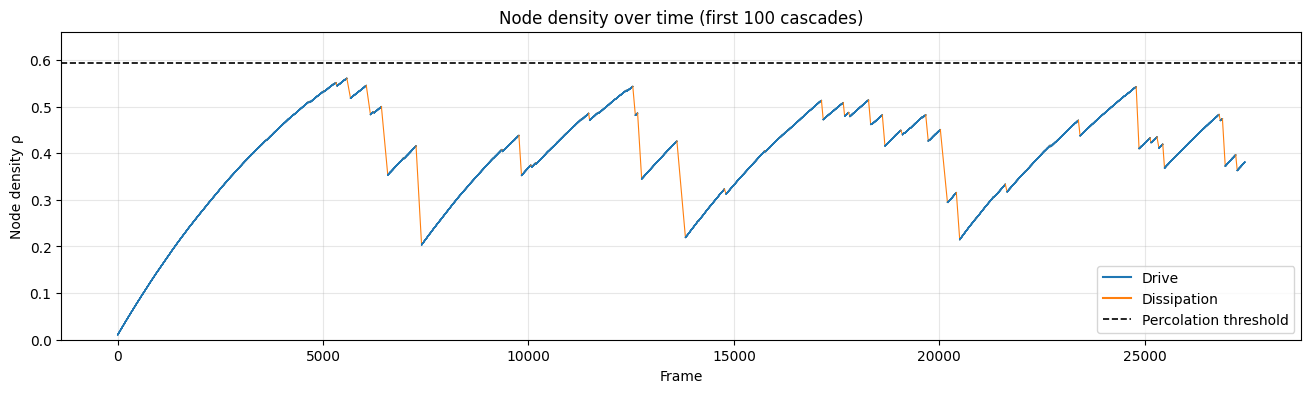

In [ ]:
# --- Slow driving, fast dissipation plot code
# Drive and release are coloured in blue and orange, respectively
# The percolation threshold for 2D lattice and Von-Neumann neighbours is shown

from matplotlib.lines import Line2D

densityPath = str(PROJECT_ROOT) + "/data/demo_short_time_series/soc_density_timeseries.txt"

dens = np.loadtxt(densityPath, delimiter=",", skiprows=1)
frames = dens[:, 0]
rho = dens[:, 1]

plt.figure(figsize=(16,4))

# Matplotlib default colours
drive_col = plt.rcParams['axes.prop_cycle'].by_key()['color'][0]   # blue
diss_col = plt.rcParams['axes.prop_cycle'].by_key()['color'][1]    # orange

# Plot the time series segment-by-segment
for i in range(len(rho)-1):
    color = drive_col if rho[i+1] >= rho[i] else diss_col
    plt.plot([frames[i], frames[i+1]],
             [rho[i], rho[i+1]],
             color=color,
             lw=0.8)

plt.xlabel("Frame")
plt.ylabel("Node density ρ")
plt.ylim(0, max(rho) + 0.1)
plt.title("Node density over time (first 100 cascades)")
plt.grid(True, alpha=0.3)

# Percolation threshold line
thresh_line = plt.axhline(
    y=0.5927,
    color="black",
    linestyle="--",
    linewidth=1.2,
    label="Percolation threshold"
)

# Legend handles
drive_handle = Line2D([0],[0], color=drive_col, lw=1.5, label="Drive")
diss_handle  = Line2D([0],[0], color=diss_col,  lw=1.5, label="Dissipation")

plt.legend(
    handles=[drive_handle, diss_handle, thresh_line],
    loc="lower right"
)

plt.show()



### 2. Emergence of a critical state

One of the defining features of self-organised criticality is that the system naturally evolves toward a **critical point** — the boundary between:
- **local, self-limiting events**, and

- **cascades capable of spanning the system**.

Crucially, the model does this **without any external tuning**. We do not set the system to be “critical”; instead, the dynamics of slow driving and fast dissipation push it toward this regime automatically.

Over time, the forest accumulates trees, builds connectivity, and occasionally burns — and the interplay of these simple rules steers the system into a state where:
- **clusters exist at all scales** (imagine something fractal-like),

- **correlations extend across large portions of the lattice**, and

- **any lightning strike could, in principle, trigger anything from a one-site spark to a system-wide cascade**.

This is what we mean by the emergence of criticality:
the system continually drifts toward — and fluctuates around — a regime where **events of all sizes are possible**. Not guaranteed, not predictable, but always *available* given the underlying structure at that moment.

This spontaneous approach to criticality is exactly what makes SOC systems such powerful analogues for complex, interconnected infrastructures: they do not need precise tuning to become fragile, only time and connectivity.


### 3. Scale-free (power-law) event size distributions

One of the clearest empirical signs of SOC is that **cascade sizes follow a power law distribution** over a substantial range:

$$P(s) \propto s^{-\tau}$$

where $s$ is the cascade size and $\tau$ is a scaling exponent. 

This captures the familiar pattern: **many small events, fewer medium ones, and very rare large ones**. The system produces cascades across all observable scales.

When we plot the event-size distribution in **log–log space**, a power law appears as an approximately straight line. This is a hallmark of a **scale-free system**: there is no characteristic event size. The system produces events at every scale permitted by its structure.

In the figure below, you will see:

- the approximate straight-line region corresponding to the power-law regime

- linear fits for both cascade size and cascade duration

- a shaded “downturn” at the far right

This final downturn is important. It is **not** evidence against scale-free behaviour — rather, it is a **finite-size effect**: our lattice is finite, so no cascade can exceed the system’s physical extent. This limitation manifests as a falling off of the tail in log–log space.

If we ran the model on a larger lattice, the straight-line region would extend further before bending down. In the limit of an infinite system, that tail would never bend.

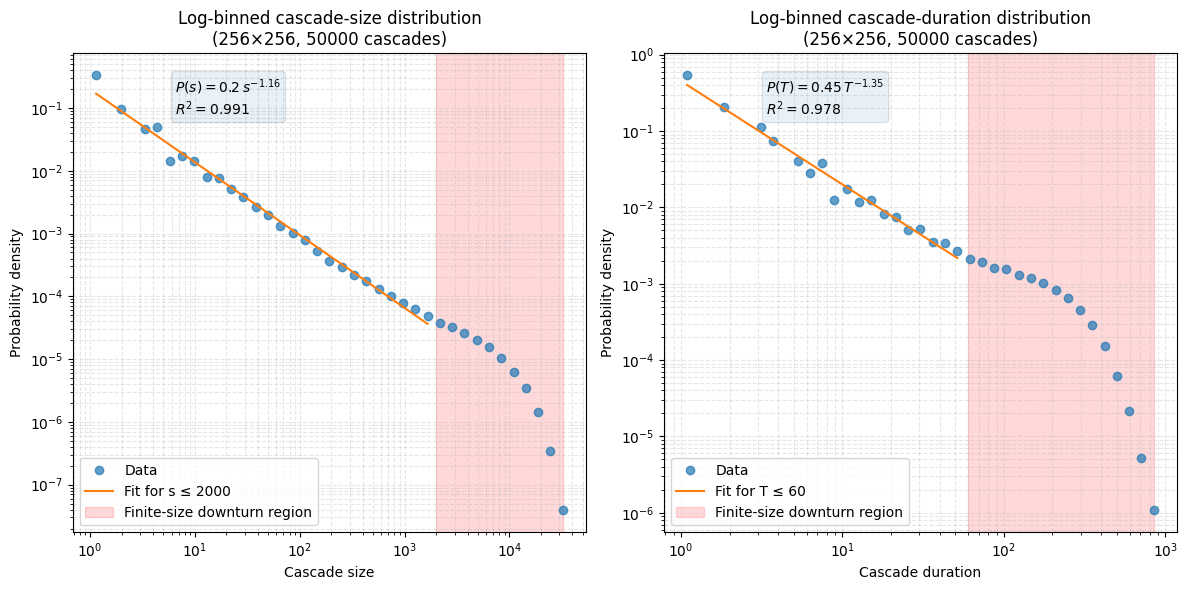

In [14]:
# --- Scale-free (power-law) plots: size and duration side by side ---
# Linear models are plotted and shaded areas highlight effects of finite lattice size

# ---------- Fire sizes file ----------
filename = myPath  # assumes myPath already points to the fire-size file

with open(filename, "r") as f:
    lines = f.read().strip().splitlines()

# --- First line: key=value parameters ---
param_line = lines[0]
param_pairs = param_line.split(",")

params = {}
for pair in param_pairs:
    if "=" in pair:
        k, v = pair.split("=", 1)
        # Try to cast to int/float where possible
        try:
            v_cast = int(v)
        except ValueError:
            try:
                v_cast = float(v)
            except ValueError:
                v_cast = v
        params[k] = v_cast

# --- Remaining lines: fire sizes ---
fire_sizes = np.array([int(x) for x in lines[1:] if x.strip().isdigit()])

# Filter positive sizes
sizes = fire_sizes[fire_sizes > 0]
N_sizes = len(sizes)

min_size = sizes.min()
max_size = sizes.max()

# Choose, say, 30–40 log bins
n_bins = 40
bins_sizes = np.logspace(np.log10(min_size), np.log10(max_size), n_bins)

counts_sizes, edges_sizes = np.histogram(sizes, bins=bins_sizes)

# Normalised counts (probability per bin)
prob_sizes = counts_sizes / N_sizes

# Geometric mean of bin edges as x-coordinate
centers_sizes = np.sqrt(edges_sizes[:-1] * edges_sizes[1:])

# PDF-like (probability per unit fire size)
bin_widths_sizes = edges_sizes[1:] - edges_sizes[:-1]
pdf_sizes = counts_sizes / (N_sizes * bin_widths_sizes)

mask_sizes = pdf_sizes > 0
centers_sizes_plot = centers_sizes[mask_sizes]
pdf_sizes_plot = pdf_sizes[mask_sizes]

# --- Fit settings for sizes ---
x_max_fit_sizes = 2e3  # limit data used for the fit

mask_fit_sizes = (
    (centers_sizes_plot > 0) &
    (pdf_sizes_plot > 0) &
    (centers_sizes_plot <= x_max_fit_sizes)
)

x_fit_sizes = centers_sizes_plot[mask_fit_sizes]
y_fit_sizes = pdf_sizes_plot[mask_fit_sizes]

log_x_sizes = np.log10(x_fit_sizes)
log_y_sizes = np.log10(y_fit_sizes)

m_sizes, b_sizes = np.polyfit(log_x_sizes, log_y_sizes, 1)
log_y_pred_sizes = m_sizes * log_x_sizes + b_sizes

# R^2 in log space
ss_res_sizes = np.sum((log_y_sizes - log_y_pred_sizes)**2)
ss_tot_sizes = np.sum((log_y_sizes - np.mean(log_y_sizes))**2)
r2_sizes = 1 - ss_res_sizes / ss_tot_sizes

# Convert fitted line back to original space
log_x_line_sizes = np.linspace(log_x_sizes.min(), log_x_sizes.max(), 200)
log_y_line_sizes = m_sizes * log_x_line_sizes + b_sizes

x_line_sizes = 10**log_x_line_sizes
y_line_sizes = 10**log_y_line_sizes

A_sizes = 10**b_sizes  # Power-law prefactor: P(s) ≈ A_sizes * s^m_sizes


# ---------- Fire durations file ----------
#myFileDur = "demo_soc_256_50000/soc_fire_durations_256_50000.txt"
myPathDur = str(PROJECT_ROOT) + "/data/demo_soc_256_50000/soc_fire_durations_256_50000.txt"

dataDur = np.loadtxt(myPathDur, delimiter=",", skiprows=2)

sizes_dur = dataDur[:, 0].astype(int)
durations = dataDur[:, 1].astype(int)

# Filter positive durations
durations = durations[durations > 0]
N_dur = len(durations)

min_duration = durations.min()
max_duration = durations.max()

# Choose, say, 30–40 log bins
bins_dur = np.logspace(np.log10(min_duration), np.log10(max_duration), n_bins)

counts_dur, edges_dur = np.histogram(durations, bins=bins_dur)

# Normalised counts (probability per bin)
prob_dur = counts_dur / N_dur

# Geometric mean of bin edges as x-coordinate
centers_dur = np.sqrt(edges_dur[:-1] * edges_dur[1:])

# PDF-like (probability per unit duration)
bin_widths_dur = edges_dur[1:] - edges_dur[:-1]
pdf_dur = counts_dur / (N_dur * bin_widths_dur)

mask_dur = pdf_dur > 0
centers_dur_plot = centers_dur[mask_dur]
pdf_dur_plot = pdf_dur[mask_dur]

# --- Fit settings for durations ---
x_max_fit_dur = 6e01  # analog to sizes; adjust if you like

mask_fit_dur = (
    (centers_dur_plot > 0) &
    (pdf_dur_plot > 0) &
    (centers_dur_plot <= x_max_fit_dur)
)

x_fit_dur = centers_dur_plot[mask_fit_dur]
y_fit_dur = pdf_dur_plot[mask_fit_dur]

log_x_dur = np.log10(x_fit_dur)
log_y_dur = np.log10(y_fit_dur)

m_dur, b_dur = np.polyfit(log_x_dur, log_y_dur, 1)
log_y_pred_dur = m_dur * log_x_dur + b_dur

# R^2 in log space
ss_res_dur = np.sum((log_y_dur - log_y_pred_dur)**2)
ss_tot_dur = np.sum((log_y_dur - np.mean(log_y_dur))**2)
r2_dur = 1 - ss_res_dur / ss_tot_dur

# Convert fitted line back to original space
log_x_line_dur = np.linspace(log_x_dur.min(), log_x_dur.max(), 200)
log_y_line_dur = m_dur * log_x_line_dur + b_dur

x_line_dur = 10**log_x_line_dur
y_line_dur = 10**log_y_line_dur

A_dur = 10**b_dur  # Power-law prefactor: P(T) ≈ A_dur * T^m_dur


# ---------- Side-by-side plots ----------
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# --- Left: cascade size distribution ---
ax1.loglog(centers_sizes_plot, pdf_sizes_plot, 'o', alpha=0.7, label="Data")
ax1.loglog(x_line_sizes, y_line_sizes, '-', label=f"Fit for s ≤ {x_max_fit_sizes:.0f}")

# Shade downturn region (beyond fit range)
x_min_shade_sizes = x_max_fit_sizes
x_max_shade_sizes = centers_sizes_plot.max()
ax1.axvspan(x_min_shade_sizes, x_max_shade_sizes, color="red", alpha=0.15,
            label="Finite-size downturn region", zorder=0)

ax1.set_xlabel("Cascade size")
ax1.set_ylabel("Probability density")
ax1.set_title("Log-binned cascade-size distribution\n"
              f"({params['grid_size']}×{params['grid_size']}, {params['max_runs']} cascades)")
ax1.grid(True, which="both", ls="--", alpha=0.3)

eq_text_sizes = (
    r"$P(s) = {:.2g}\,s^{{{:.2f}}}$".format(A_sizes, m_sizes) + "\n" +
    r"$R^2 = {:.3f}$".format(r2_sizes)
)

ax1.text(
    0.2, 0.95, eq_text_sizes,
    transform=ax1.transAxes,
    va="top", ha="left",
    bbox=dict(boxstyle="round", alpha=0.1)
)

ax1.legend()


# --- Right: cascade duration distribution ---
ax2.loglog(centers_dur_plot, pdf_dur_plot, 'o', alpha=0.7, label="Data")
ax2.loglog(x_line_dur, y_line_dur, '-', label=f"Fit for T ≤ {x_max_fit_dur:.0f}")

# Shade downturn region (beyond fit range)
x_min_shade_dur = 6e01
x_max_shade_dur = centers_dur_plot.max()
ax2.axvspan(x_min_shade_dur, x_max_shade_dur, color="red", alpha=0.15,
            label="Finite-size downturn region", zorder=0)

ax2.set_xlabel("Cascade duration")
ax2.set_ylabel("Probability density")
ax2.set_title("Log-binned cascade-duration distribution\n"
              f"({params['grid_size']}×{params['grid_size']}, {params['max_runs']} cascades)")
ax2.grid(True, which="both", ls="--", alpha=0.3)

eq_text_dur = (
    r"$P(T) = {:.2g}\,T^{{{:.2f}}}$".format(A_dur, m_dur) + "\n" +
    r"$R^2 = {:.3f}$".format(r2_dur)
)

ax2.text(
    0.2, 0.95, eq_text_dur,
    transform=ax2.transAxes,
    va="top", ha="left",
    bbox=dict(boxstyle="round", alpha=0.1)
)

ax2.legend()

plt.tight_layout()
plt.show()


#### A note on log–log plots

Logging both axes allows us to visualise data that span many orders of magnitude without compressing small events or exploding the scale at the upper end. When the relationship between the logged variables forms a straight line, it indicates a multiplicative, scale-free structure in the underlying data.


#### Cascade size vs duration (log–log): interpreting the bounds

Alongside the power-law distributions for **size** and **duration** separately, we can also examine their **relationship** by plotting cascade size against cascade duration in log–log space (shown below).

In the forest-fire model, physical constraints impose theoretical bounds on how size and duration can scale:

- **a slope of 1** (upper bound): would correspond to a cascade expanding roughly linearly in space and time — every additional time step ignites a broadly similar number of new sites.

- **a slope of 0.5** (lower bound): corresponds to a more diffusion-like spread, where the spatial extent grows roughly with the square root of time.

These two lines are not predictions of the Drossel–Schwabl model per se; rather, they define the *possible geometric envelope* within which cascades must lie, given local propagation rules.

When we plot the actual simulated data, the cascade points form a relatively **thin cloud** between these two bounds. They tend to cluster **closer to the upper limit** rather than the lower one. This suggests that:

- **large cascades tend to propagate efficiently** through the available nodes

- **their duration does not increase as fast as their size**, meaning they dissipate comparatively quickly once they get going

Another way to put this: once ignition reaches a part of the lattice with strong connectivity, the cascade front sweeps through in a short number of steps. Duration is therefore *sublinear* in size, but still strongly constrained by the geometry of the lattice.

This behaviour is consistent with SOC intuition: **large cascades are rare, but when they occur, the structure of the system supports rapid, system-spanning propagation**.

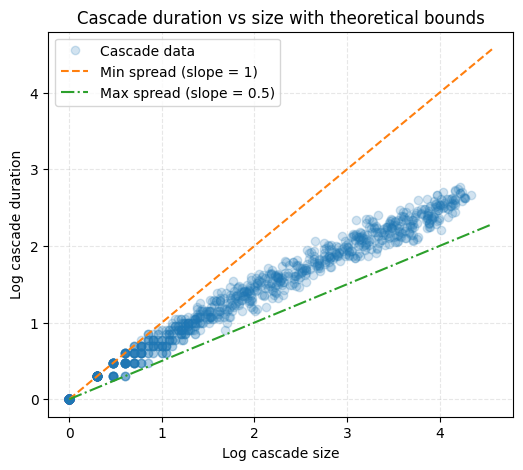

In [15]:
# --- Cascade (log) size vs (log) duration plot
# With min and max spread bounds

# Raw data (sizes, durations)
x = np.log10(sizes)
y = np.log10(durations)

plt.figure(figsize=(6,5))
plt.plot(x[:1000], y[:1000], "o", alpha=0.2, label="Cascade data")

# Generate bounding lines
x_line = np.linspace(min(x), max(x), 200)

# Anchor at smallest event
x0 = min(x)
y0 = min(y)

# Lower envelope: slope 1 (slowest possible)
c_min = y0 - 1 * x0
y_min_line = 1 * x_line + c_min

# Upper envelope: slope 0.5 (geometric spreading in 2D)
c_max = y0 - 0.5 * x0
y_max_line = 0.5 * x_line + c_max

# Plot the envelopes
plt.plot(x_line, y_min_line, '--', label="Min spread (slope = 1)")
plt.plot(x_line, y_max_line, '-.', label="Max spread (slope = 0.5)")

plt.xlabel("Log cascade size")
plt.ylabel("Log cascade duration")
plt.legend()
plt.grid(True, ls="--", alpha=0.3)
plt.title("Cascade duration vs size with theoretical bounds")
plt.show()


### 4. Long-range correlations

A system near criticality does not just produce events of many sizes — it also develops **structures that span large portions of the system**. In the forest-fire model, this takes the form of **connected clusters of trees** that allow a fire to travel far if ignited. The more extensive this connectivity, the farther a cascade can propagate.

The quantity that captures this large-scale structure is the **correlation length**, denoted $\xi$.
Intuitively, $\xi$ measures the typical “reach” of connectivity present in the system at a given moment.


### Measuring correlation length using the radius of gyration

In the forest model, each cascade originates from the pre-burn lattice — the pattern of trees present just before ignition. We estimate the correlation length by computing the **radius of gyration** $R_g$ of the connected cluster that will burn.

For a cluster consisting of points $(x_i,y_i)$, we define each point’s position vector:

$$\mathbf{r}_i = (x_i, y_i)$$

The cluster's centroid (centre of mass) $\mathbf{r}_{cm}$ is:
$$\qquad \mathbf{r}_{\mathrm{cm}} = \frac{1}{N} \sum_{i=1}^{N} \mathbf{r}_i$$

The **radius (or axis) of gyration** $R_g$ (and therefore the approximate value of $\xi$) is then:
$$\xi \equiv R_g = \sqrt{ \frac{1}{N} \sum_{i=1}^{N} \left\lVert \mathbf{r}_i - \mathbf{r}_{\mathrm{cm}} \right\rVert^2 }$$

This measures how “spread out” the cluster is relative to its centre. Large clusters have a large $R_g$. At criticality, the distribution of $R_g$ typically develops a long right tail, reflecting the emergence of extended, lattice-spanning connectivity.

In the left-hand plot below, you can see this right-tailed distribution of correlation lengths $\xi$.


### Correlation length in relation to cascade size

The second plot shows correlation length vs cascade size, revealing a characteristic pattern:

- **Small cascades** arise from purely local structures and occur regardless of the global level of connectivity. They occupy the flat, low-$\xi$ region of the plot.

- **Large cascades** only occur when the lattice contains extensive connectivity — that is, when $\xi$ is large.

This produces a distinctive V-shaped relationship:

- **The left branch**: small cascades occur everywhere and are unaffected by $\xi$.

- **The right branch**: large cascades require large $\xi$, and in this finite system the upper envelope grows almost linearly with correlation length.

In an infinite system, asymptotic theory would predict power-law scaling.
But in our finite lattice, geometry dominates: once a cluster has grown to system-scale, its radius of gyration increases proportionally with the physical extent of the lattice, giving the near-linear upper boundary we observe.

In [17]:
# --- Correlation-length calculation

# Load the saved lattice states
data = np.load(str(PROJECT_ROOT) + "/data/demo_correlation_length/socsim_output_preburn_states.npz")
lattices = data["states"]     # shape: (N_fires, L, L)
num_fires, L, _ = lattices.shape

from collections import deque

# Cluster-labelling (von Neumann connectivity)
def find_clusters(occ, connectivity=4):
    """
    occ: 2D boolean array. True = tree, False = empty
    connectivity: 4 or 8
    returns list of arrays of (i, j)
    """
    occ = occ.astype(bool)
    visited = np.zeros_like(occ, dtype=bool)
    clusters = []
    n, m = occ.shape

    if connectivity == 4:
        neigh = [(1,0), (-1,0), (0,1), (0,-1)]
    elif connectivity == 8:
        neigh = [(1,0), (-1,0), (0,1), (0,-1), (1,1), (1,-1), (-1,1), (-1,-1)]
    else:
        raise ValueError("Connectivity must be 4 or 8")

    for i in range(n):
        for j in range(m):
            if occ[i,j] and not visited[i,j]:
                q = deque([(i,j)])
                visited[i,j] = True
                coords = []

                while q:
                    x,y = q.popleft()
                    coords.append((x,y))
                    for dx,dy in neigh:
                        nx, ny = x+dx, y+dy
                        if 0 <= nx < n and 0 <= ny < m:
                            if occ[nx,ny] and not visited[nx,ny]:
                                visited[nx,ny] = True
                                q.append((nx,ny))

                clusters.append(np.array(coords, dtype=int))
    
    return clusters

# Compute cluster sizes + correlation length for each lattice slice
def correlation_length_from_clusters(clusters):
    """
    clusters: list of (k_i x 2) arrays of (row, col)
    returns xi (float)
    """
    num = 0.0
    den = 0.0
    for coords in clusters:
        s = coords.shape[0]
        if s <= 1:
            continue
        center = coords.mean(axis=0)
        d2 = ((coords - center)**2).sum(axis=1)
        R2 = d2.mean()
        num += s * R2
        den += s
    return np.sqrt(num / den) if den > 0 else 0.0

# Compute for all pre-burn states:
cluster_sizes_per_fire = []
correlation_lengths = []

for k in range(num_fires):
    occ = lattices[k] == 1     # tree = True
    clusters = find_clusters(occ, connectivity=4)
    
    # All cluster sizes for this lattice
    sizes = [c.shape[0] for c in clusters]
    cluster_sizes_per_fire.append(sizes)

    # Correlation length
    xi = correlation_length_from_clusters(clusters)
    correlation_lengths.append(xi)

correlation_lengths = np.array(correlation_lengths)

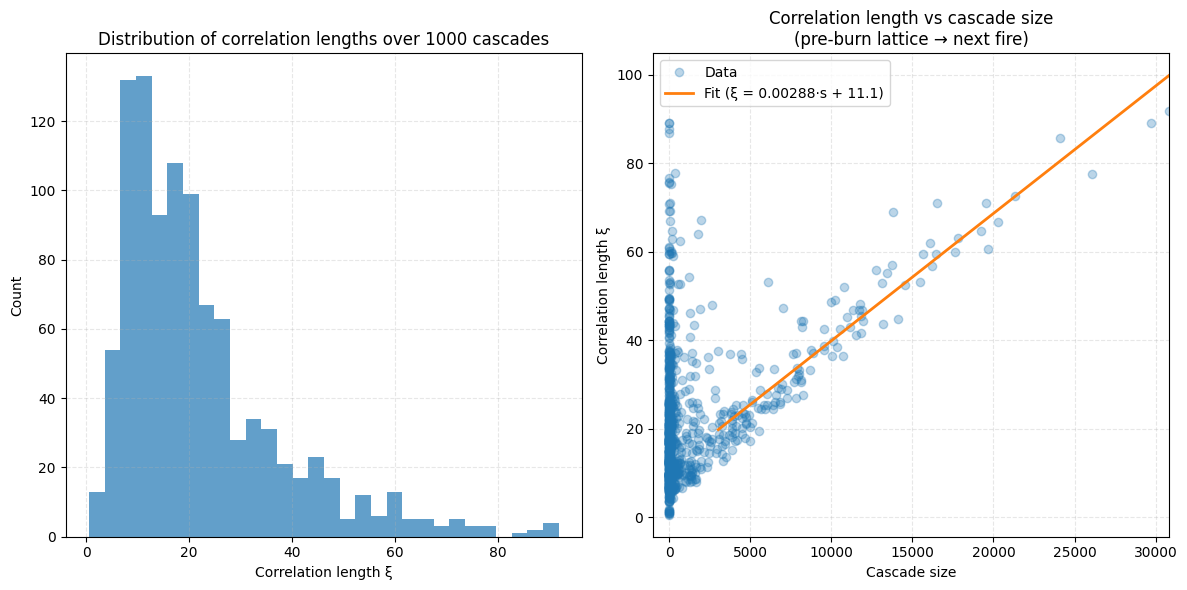

In [18]:
# --- Prepare data for both plots (uses existing correlation_lengths)

# Histogram data already in `correlation_lengths`

# Load fire sizes for correlation length vs cascade size
with open(str(PROJECT_ROOT) + "/data/demo_correlation_length/socsim_output_fire_sizes.txt", "r") as f:
    lines = f.read().strip().splitlines()

fire_sizes_cl = np.array([int(x) for x in lines[1:] if x.strip().isdigit()])

# Linear fit on the right-hand side of the V-shape
fit_x = fire_sizes_cl[fire_sizes_cl > 3000]
fit_y = correlation_lengths[fire_sizes_cl > 3000]

m, c = np.polyfit(fit_x, fit_y, 1)

# Smooth line for plotting
x_line = np.linspace(fit_x.min(), fit_x.max(), 200)
y_line = m * x_line + c

# --- Side-by-side plots ---
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Left: distribution of correlation lengths
ax1.hist(correlation_lengths, bins=30, alpha=0.7)
ax1.set_xlabel("Correlation length ξ")
ax1.set_ylabel("Count")
ax1.set_title("Distribution of correlation lengths over 1000 cascades")
ax1.grid(True, ls="--", alpha=0.3)

# Right: correlation length vs cascade size with linear fit
ax2.plot(fire_sizes_cl, correlation_lengths, "o", alpha=0.3, label="Data")
ax2.plot(x_line, y_line, "-", linewidth=2,
         label=f"Fit (ξ = {m:.3g}·s + {c:.3g})")

ax2.set_xlabel("Cascade size")
ax2.set_ylabel("Correlation length ξ")
ax2.set_title("Correlation length vs cascade size\n(pre-burn lattice → next fire)")
ax2.grid(True, which="both", ls="--", alpha=0.3)
ax2.set_xlim(-1000, max(fire_sizes_cl))
ax2.legend()

plt.tight_layout()
plt.show()



### 5. Intermittency and burstiness

Self-organised critical systems do not release energy—or experience cascades—at regular, predictable intervals. Instead, they exhibit **intermittent** behaviour: long stretches of quiet accumulation punctuated by **bursts** of activity. This pattern arises naturally from the slow–fast dynamics discussed earlier: the system spends most of its life rebuilding structure, then occasionally sheds large amounts of it in rapid events.

This is why the **barcode plot** below — where each vertical line marks the occurrence of a cascade — looks irregular, uneven and clustered. Periods of high activity appear next to long quiet stretches; small cascades appear in flurries; and rare large ones occur seemingly without warning.

This irregular, bursty rhythm is not noise. It is a hallmark of SOC systems, reflecting the fact that the system’s internal structure — not an external clock — governs when cascades occur and how large they become.

The forest-fire model displays this vividly, and the same pattern often appears in complex engineered systems: quiet operational periods punctuated by sudden outages, failures or overload events.

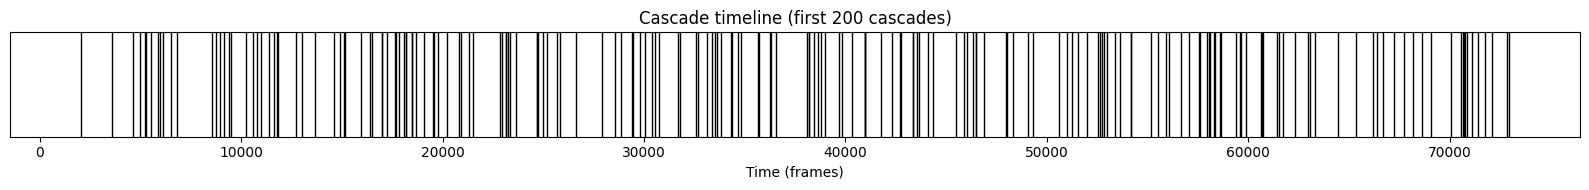

In [19]:
# --- Plot of intermittency and burstiness
# Barcode plot

densityPath = str(PROJECT_ROOT) + "/data/demo_long_time_series/socsim_output_density_timeseries.txt"

dens = np.loadtxt(densityPath, delimiter="\t", skiprows=1)
rho = dens[:,1]

rho = np.array(rho)  # ensure numpy array

# 1. Find indices where density drops
drop_indices = np.where(rho[1:] < rho[:-1])[0] + 1

# 2. Cascade start times (one step earlier)
cascade_starts = drop_indices - 1

# 3. Compute waiting times between cascades
waiting_times = np.diff(cascade_starts)

cascade_starts_200 = cascade_starts[:200]
plt.figure(figsize=(16,2))
plt.vlines(cascade_starts_200, ymin=0, ymax=1, color='black', linewidth=1)
plt.ylim(0, 1)
plt.yticks([])
plt.xlabel("Time (frames)")
plt.title("Cascade timeline (first 200 cascades)")
plt.tight_layout()
plt.show()


### 6. Sensitivity to small perturbations

As a system approaches its critical state, its behaviour becomes increasingly sensitive to small, local perturbations. A single-cell change — a lightning strike landing on the right cluster, a tree that happened to grow in a bridging position, a misconfigured device or an exposed service coming online — can trigger a cascade far larger than the disturbance itself.

This **sensitive dependence on local configuration** is another defining feature of SOC systems. The system’s global behaviour is shaped not by the size of the trigger, but by the connectivity available at that moment. Two identical lightning strikes can produce radically different outcomes purely because the underlying structure has shifted.

This is why SOC systems often feel unpredictable from the outside: the event size is determined not by the initiating event but by the **stored structure** of the system. Small disturbances can remain small, or they can unlock large-scale dynamics that have been quietly accumulating.

No dedicated plot is needed here. The point is conceptual rather than statistical, and the behaviour is already visible in the earlier cascade size histograms, barcode plots and correlation-length relationships.

---

## Before we move on: two essential background concepts

Before we continue, it is worth pausing to clarify a couple of ideas that appeared implicitly throughout the six core characteristics of SOC systems. These concepts — **percolation** and **finite-size effects** — underpin much of the behaviour we have already seen. Understanding them now will make later material (including network analogues) more intuitive.


### Percolation and the Percolation Threshold

Percolation theory describes how **connected clusters emerge in random media**. It tells us the conditions under which local connections suddenly form **system-spanning structures**.

On a square lattice with **von Neumann** connectivity, there is a well-known **site percolation threshold**:

$$p_c \approx 0.5927$$

If the fraction of “occupied” sites (trees) is:

- **below** $p_c$: clusters are small; long-range spread is unlikely

- **near** $p_c$: very large clusters begin to appear, and the correlation length grows sharply

- **above** $p_c$: a giant connected component emerges, enabling rapid traversal of the entire lattice

In the Drossel–Schwabl forest-fire model, the density naturally fluctuates *near but typically below* the percolation threshold. This quasi-critical regime is what allows cascades of all sizes to occur: the system repeatedly drifts toward conditions where long-range connectivity is possible but not guaranteed.

Percolation also provides a conceptual bridge to cyber systems. On a network, it maps directly onto:

- connectivity

- reachability

- blast radius of failures

- epidemic thresholds in malware propagation

- structural fragility or robustness

Percolation, in other words, gives us the language for understanding *how far* a cascade can spread given the system’s connectivity.


### Finite-size effects

Everything we have observed so far comes from a **finite** lattice. This matters because finite systems cannot display true scale-free behaviour across an unlimited range — there is always a **maximum event** size set by the system’s physical size.

Finite-size effects appear in our analysis in several places:

- In the **power-law size and duration plots**, the tail “bends down” instead of extending indefinitely.

- In the **correlation-length distribution**, we see a maximum $R_g$ corresponding to clusters that span the lattice.

- In the **size–duration relationships**, the upper envelope becomes geometric and nearly linear, reflecting the finite width of the lattice.

In an infinite system, these curves would continue without such truncation.

In a finite system — including real cyber infrastructures — constraints impose upper limits that shape the observed statistics. Recognising these effects prevents us from misinterpreting the downturns as deviations from SOC; they are simply artefacts of bounded geometry.


### And one bonus concept: Critical fluctuations

One final idea worth keeping in mind is that near criticality, **the system continuously fluctuates between more and less connected states**. There is no stable “critical density.” Instead, the forest oscillates through configurations that sometimes support long-range propagation and sometimes do not.

These fluctuations explain:

- why large cascades do not require density to be extremely close to $p_c$

- why density occasionally sits far below threshold yet still permits sizeable events

- why sensitivity to small perturbations increases without the system “locking in” to a fixed configuration

This concept will become especially useful later when we transition from spatial lattices to **networks**, where criticality does not manifest as a simple global parameter but as a structural property distributed across the graph.

---

## Bringing it together

At this point, we have seen the essential features that define a self-organised critical system. Taken together, they show why these models behave in such striking and unpredictable ways, and why they are so useful for understanding complex infrastructures.

To compress the core idea:

#### **Self-organising** because the system drives itself toward the critical point without any external tuning — slow build-up, fast release, and an internal structure that continually reorganises.

#### **Critical** because the event sizes become scale-free, spanning all available scales, and it becomes inherently difficult to predict **when** an event will occur or **how large** it will be.

A system in this regime is neither ordered nor chaotic, but balanced on the boundary between them. This is where long-range structure emerges, cascades propagate, and small perturbations can unlock large consequences.

If the reader has followed this far, they now understand what the term **self-organised criticality** really means — not as a slogan, but as a set of concrete, observable behaviours.

With that foundation in place, we can now turn to the world we ultimately care about: **networked systems and cyber topologies**, where the geometry is far less visually obvious but the same underlying principles shape how cascades move, grow and dissipate.

Take a breather — then let’s dive in.

---

## References and Resources

Good, accessible references for the concepts used here include:

Veritasium (YouTube) - You've likely been playing the game of life wrong 
https://www.youtube.com/watch?v=HBluLfX2F_k

Wikipedia — Forest-fire model (Drossel–Schwabl SOC model)
https://en.wikipedia.org/wiki/Forest-fire_model

Wikipedia — Self-organised criticality
https://en.wikipedia.org/wiki/Self-organized_criticality

Wikipedia — Percolation theory overview
https://en.wikipedia.org/wiki/Percolation_theory

Drossel & Schwabl (1992). Self-Organized Critical Forest-Fire Model.
Physical Review Letters, 69, 1629–1632

Bak, Tang & Wiesenfeld (1987). Self-Organized Criticality: An Explanation of $1/f$ Noise.
Physical Review Letters. A classic.

Jensen (1998). Self-Organized Criticality. Cambridge University Press.
A strong textbook introduction.

---